# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib import colors
import seaborn as sns
%matplotlib inline


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [3]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

In [4]:
#look at the dataframe head
data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


**Question 1.1**

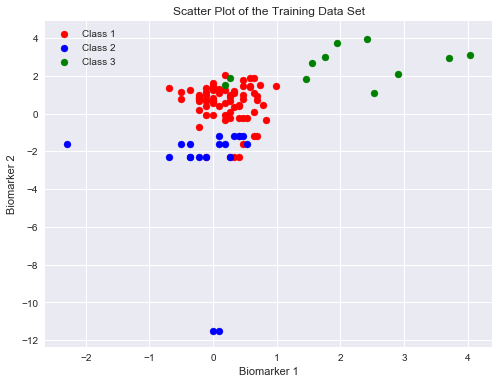

In [5]:
# generate a numpy array of possible responses 
responses = sorted(data_train.Diagnosis.unique())
colors = ['r','b','g']

plt.figure(figsize = (8,6))

for i in range(len(responses)):
    response = responses[i]
    msk = data_train['Diagnosis'] == response 
    plt.scatter(data_train['Biomarker 1'][msk], data_train['Biomarker 2'][msk], 
                c = colors[i],label = 'Class ' + str(int(response)))
    
plt.legend()
plt.title('Scatter Plot of the Training Data Set')
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.show()

Yes, it appears that a linear classifier will work well. By inspection, a linear classifier should be able to correctly classify >90% of the training data points

**Question 1.2**

The difference between multinomial logistic regression and OvR was explained in class so you should refer to the second logistic regression lecture notes for the answer. 


**Question 1.3**

In [6]:
"""

Note that both OVR and Multinomial Logistic Regression are implemented in SKLearn, chosen with the argument 
'multi_class' - Solver implements some variant of Newton Raphson algorithm, and LogisticRegressionCV by default 
implements L2 Regularization and picks the optimal regularization parameter

"""

#One v. Rest
lrm_ovr = LogisticRegressionCV(multi_class = 'ovr')
lrm_ovr.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

#Multinomial - according to the documentation, the liblinear solver doesn't work for multinomial
lrm_multinomial = LogisticRegressionCV(multi_class = 'multinomial', solver = 'newton-cg')
lrm_multinomial.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

#Computing the score on the test set - 
print('OVR Logistic Regression Test Score: ',lrm_ovr.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))
print('Multinomial Logistic Regression Test Score: ',lrm_multinomial.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))

OVR Logistic Regression Test Score:  0.840707964602
Multinomial Logistic Regression Test Score:  0.884955752212


Multinomial does better than One vs. Rest on this particular split of the data


**Question 1.4**

In [11]:

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])
qda.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])


max_score = 0
max_k = 0 

for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn,data_train.iloc[:,:-1],data_train.iloc[:,-1]).mean()
    if score > max_score:
        max_k = k
        max_score = score
 

knn = KNeighborsClassifier(n_neighbors = max_k)
knn.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('KNN Test Score:', '(Best K is ' + str(max_k) +')',  knn.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))
print('LDA Test Score: ',lda.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))
print('QDA Test Score: ',qda.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))

poly = PolynomialFeatures(degree = 2, include_bias = False)
X_poly_train = poly.fit_transform(data_train.iloc[:,:-1])
X_poly_test = poly.fit_transform(data_test.iloc[:,:-1])
lrm_ovr2 = LogisticRegressionCV(multi_class = 'ovr')
lrm_ovr2.fit(X_poly_train,data_train.iloc[:,-1])
lrm_multinomial2 = LogisticRegressionCV(multi_class = 'multinomial', solver = 'newton-cg')
lrm_multinomial2.fit(X_poly_train,data_train.iloc[:,-1])


print('OVR Poly Logistic Regression Test Score: ',lrm_ovr2.score(X_poly_test,data_test.iloc[:,-1]))
print('Multinomial Poly Logistic Regression Test Score: ',lrm_multinomial2.score(X_poly_test,data_test.iloc[:,-1]))

KNN Test Score: (Best K is 3) 0.867256637168
LDA Test Score:  0.83185840708
QDA Test Score:  0.849557522124
OVR Poly Logistic Regression Test Score:  0.87610619469
Multinomial Poly Logistic Regression Test Score:  0.893805309735


Training scores for these models are ommited

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [12]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

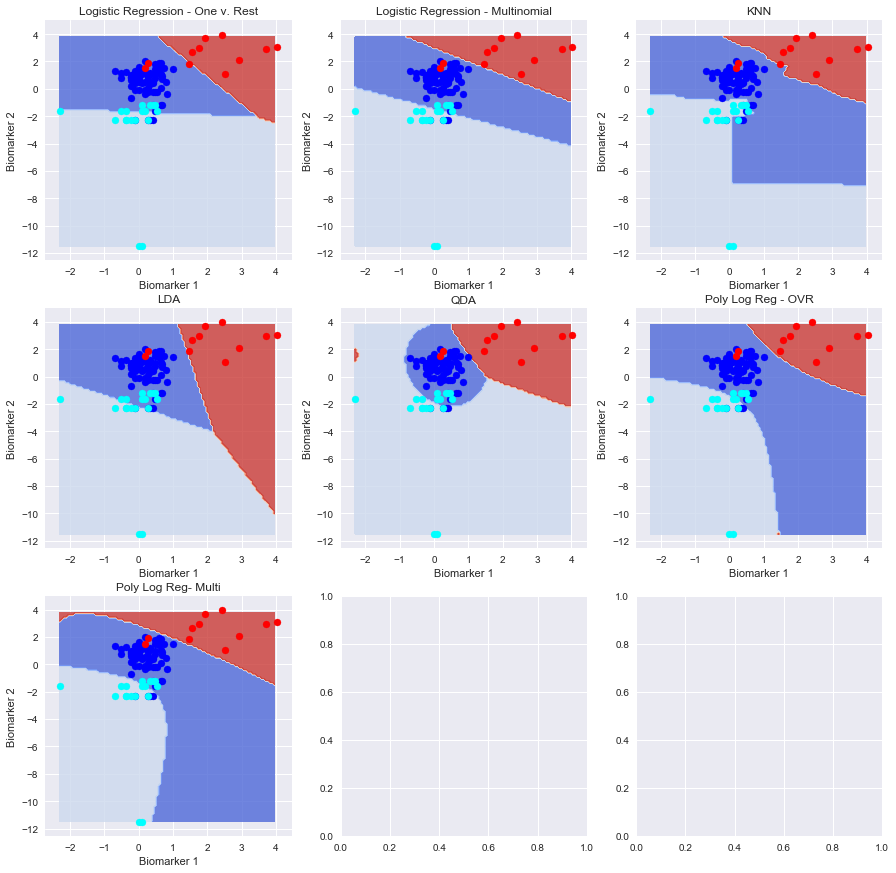

In [13]:
fitted_models = [lrm_ovr, lrm_multinomial, knn, lda, qda, lrm_ovr2, lrm_multinomial2]
titles = ['Logistic Regression - One v. Rest', 'Logistic Regression - Multinomial','KNN','LDA','QDA',
         'Poly Log Reg - OVR', 'Poly Log Reg- Multi']

f, axes = plt.subplots(3, 3, figsize = (15,15))
c = 0 
for i in range(len(axes)):
    for j in range(len(axes[0])):
        mod = fitted_models[c]
               
        #hard code the degree of the polynomial ones
        deg = None
        if c == 5 or c == 6:
            deg = 2
            
        plot_decision_boundary(data_train.iloc[:,:-1].values, data_train.iloc[:,-1].values, 
                               mod, titles[c], axes[i,j], poly_degree=deg)
        c += 1
        
        if c == len(fitted_models):
            break
  

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

**Question 3.1**

In [10]:
depths = [i for i in range(2, 11)]
train_scores = []
test_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])
    train_scores.append(clf.score(data_train.iloc[:,:-1],data_train.iloc[:,-1]))
    test_scores.append(clf.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))

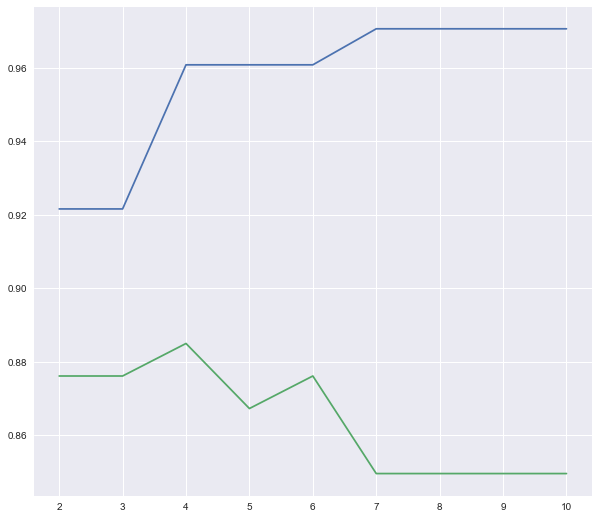

In [16]:
plt.figure(figsize=(10, 9))
plt.plot(depths, train_scores)
plt.plot(depths, test_scores)

**Question 3.2**

In [20]:
total_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)  
    # Perform 5-fold cross validation 
    score = cross_val_score(estimator=clf, X=data_train.iloc[:,:-1], y=data_train.iloc[:,-1], cv=5)
    total_scores.append((depth, np.mean(score)))

In [21]:
total_scores

[(2, 0.91314650262018693),
 (3, 0.8930963773069035),
 (4, 0.86395534290271137),
 (5, 0.87347915242652086),
 (6, 0.86395534290271137),
 (7, 0.86395534290271137),
 (8, 0.86395534290271137),
 (9, 0.86395534290271137),
 (10, 0.86395534290271137)]

In [34]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(data_train.iloc[:,:-1], data_train.iloc[:,-1])
print ('Train score:', clf.score(data_train.iloc[:,:-1], data_train.iloc[:,-1]))
print ('Test score:', clf.score(data_test.iloc[:,:-1], data_test.iloc[:,-1]))

Train score: 0.921568627451
Test score: 0.87610619469


**Question 3.3**

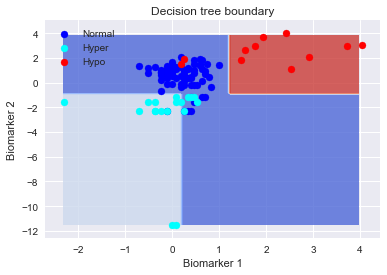

In [35]:
fig, ax = plt.subplots(1, 1)
plot_decision_boundary(data_train.iloc[:,:-1].values, data_train.iloc[:,-1].values, clf, 'Decision tree boundary', ax)
ax.legend()

**Question 3.4**

In [36]:
export_graphviz(clf, out_file='tree_viz.dot')

<img src="files/tree.png">

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

<img src="files/rankings.png">

**Classification performance:**
Use the values derived from earlier questions to make the comparison.


**Complexity of decision boundary**
Discuss graphs above. Make sure their answers are reasonable and follow the graph.

**Memory Storage**
Big O notation is acceptable but not necessary. Can talk about it in the context of parametric vs nonparametric, hyperparameter tuning, issues with higher dimensionality etc. Just nothing egregiously wrong.

**Ease of interpretability**
Again, flexible and as long as it makes sense. Can talk about it in terms of if ease of interpretability changes as dimensions change, how easy it is to understand why the model made certain decisions/how to logically verify why it performs well or it doesn't perform well etc.

Allow them to choose whatever method they'd like as long as they sufficiently back it up. They should refer to each of the 4 categories above.

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**Question 5.0**

Assuming the OvR logistic regression model, we estimate $p_j$ for $j\in \{1,2,3\}$, the marginal probability of being in each class, and then normalize these to sum to 1 (handled by sklearn). The normalization step is not necessary for the multinomial model, since the softmax function is already constrained to sum to 1. 

Following the hint, we will proceed by using the trained OvR logistic regression model to estimate $\hat{p}_j$ and then making a decision based on minimizing the expected cost. The expected cost for abstaining is \$1000. The expected cost for predicting is \$ $5000 * P(\text{misdiagnosis}) = 5000 * (1 - \hat{p}_k)$ where $k$ is the label of the predicted class. 

So our decision rule is if $5000 * (1 - \hat{p}_k) < 1000$, attempt a prediction. Otherwise, abstain.

**Question 5.1**

In [18]:
#we will take the convention that 0 is the abstain option

def cost(decisions, val):
    
    #number of times abstained
    cost = 1000 * len(decisions[decisions == 0])
    
    true_vals = val[decisions != 0]
    predicted_vals = decisions[decisions !=0]
    
    #number of incorrect predictions
    cost += 5000* sum(true_vals != predicted_vals)
    
    return(cost)


#for the first part of the question the decisions are just the predictions

dec = lrm_ovr.predict(data_test.iloc[:,:-1].values) 
vl = data_test.iloc[:,-1].values
print("Cost incurred for OvR Logistic Regression Model: $", cost(dec,vl)/len(vl))

Cost incurred for OvR Logistic Regression Model: $ 796.460176991


In [19]:
#new decision rule, for the second part of the problem 
def decision_rule(lrm_mod,input_data):
    probs = lrm_mod.predict_proba(input_data)
    predicted_class = np.argmax(probs,axis = 1) + 1
    conf = 1.0 - np.max(probs,axis = 1)
    predicted_class[5000*conf > 1000.0] = 0
    return(predicted_class)

dec2 = decision_rule(lrm_ovr,data_test.iloc[:,:-1].values)
print("Cost incurred for new model: $", cost(dec2,vl)/len(vl))

Cost incurred for new model: $ 637.168141593


Note that there are numerous acceptable solutions for this problem. This is the bare minimum for the question and a full points answer will go into more detail describing justification for the strategy. Answers that chose parameters arbitrarily lost points. Any parameter for your model should be chosen only looking at the training set. 

**Question 5.2** 

The slides are open ended, so here we will just list the criteria for grading:

- Grading was done on the basis of: 
    - Your slides were clear and communicated effectively, without being overly technical
    - You explained how your approach would be robust to changes in the costs of using the abstain option.
    - Visuals are effective and aesthetically pleasing